In [1]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

In [2]:
save_model = 'D:/projects/ai/poc/homework/training_model.h5'

In [3]:
# 根据箱线图的上下限进行异常值的填充
def boxplot_fill(col):
    # 计算iqr：数据四分之三分位值与四分之一分位值的差
    iqr = col.quantile(0.75)-col.quantile(0.25)
    # 根据iqr计算异常值判断阈值
    u_th = col.quantile(0.75) + 1.5*iqr # 上界
    l_th = col.quantile(0.25) - 1.5*iqr # 下界
    # 定义转换函数：如果数字大于上界则用上界值填充，小于下界则用下界值填充。
    def box_trans(x):
        if x > u_th:
            return u_th
        elif x < l_th:
            return l_th
        else:
            return x
    return col.map(box_trans)
def iqr(df, colname, bounds = [.25, .75]):
    s = df[colname]
    q = s.quantile(bounds)
    return df[~s.clip(*q).isin(q)]
# def cap(x,quantile=[0.01,0.99]):
#     """盖帽法处理异常值
#     Args：
#         x：pd.Series列，连续变量
#         quantile：指定盖帽法的上下分位数范围
#     """

# # 生成分位数
#     Q01,Q99=x.quantile(quantile).values.tolist()

# # 替换异常值为指定的分位数
#     if Q01 > x.min():
#         x = x.copy()
#         x.loc[x<Q01] = Q01

#     if Q99 < x.max():
#         x = x.copy()
#         x.loc[x>Q99] = Q99

#     return(x) 

In [4]:
def MFGDate(_date):
    if _date.dt.hour < '07:30' :
       return _date.dt.time

    else:
       return _date+ pd.Timedelta(days=-1)


In [5]:
df_train = pd.read_csv('D:/projects/ai/poc/homework/training_data_20210128.csv')
# 刪除null值


# df=df.head(1000)
#df = pd.read_excel(source_file_path)
#df = pd.read_csv(source_file_path)
df_train = df_train.loc[df_train['LOT_TYPE']=='FDY']
df_train = df_train.loc[df_train['LAYER']!='XX']

df_train['CHIPNAME'] = df_train['CHIPNAME'].str.strip()
df_train = df_train.loc[df_train['CHIPNAME']=='CHIP266']          

df_train['PRIORITY'] = df_train['PRIORITY'].astype(str)
df_train['IS_MAIN_ROUTE'] = df_train['IS_MAIN_ROUTE'].astype(str)
df_train['DATA_DATE'] = df_train['DATA_DATE'].astype(str)
          
df_train['DATA_DATE'] = pd.to_datetime(df_train['DATA_DATE'], infer_datetime_format=True)
df_train['WS_DATE'] = pd.to_datetime(df_train['WS_DATE'], infer_datetime_format=True)

# df_train = df_train.assign(PROCESSED_DAYS = ((df_train['DATA_DATE'] -df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_train = df_train.assign(PROCESSED_DAYS = ((df_train['DATA_DATE'] -df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
df_train['ACTUAL_WP_OUT'] =pd.to_datetime(df_train['ACTUAL_WP_OUT'], infer_datetime_format=True)

# df_train = df_train.assign(CYCLE_TIME=((df_train['ACTUAL_WP_OUT']-df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_train = df_train.assign(CYCLE_TIME=((df_train['ACTUAL_WP_OUT']-df_train['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
# df_train = df_train.assign(REMAIN_DAYS=((df_train['ACTUAL_WP_OUT']-df_train['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_train = df_train.assign(REMAIN_DAYS=((df_train['ACTUAL_WP_OUT']-df_train['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
#計算LAYER_REMAIN_DAYS
conditions = [df_train['LAYER'].eq(layer) for layer in df_train['LAYER'].unique()]
choices = [df_train[f'{layer}'] for layer in df_train['LAYER'].unique()]
df_train['LAYER_REMAIN_DAYS'] = np.select(conditions, choices)


In [6]:
#print(sum(pd.isnull(df_train['REMAIN_LAYER_SEQ'])))

In [7]:
df_test = pd.read_csv('D:/projects/ai/poc/homework/testing_data_20210128.csv')

df_test = df_test.loc[df_test['LOT_TYPE']=='FDY']
df_test = df_test.loc[df_test['LAYER']!='XX']
df_test['CHIPNAME'] = df_test['CHIPNAME'].str.strip()
df_test = df_test.loc[df_test['CHIPNAME']=='CHIP266']   
     

df_test['PRIORITY'] = df_test['PRIORITY'].astype(str)
df_test['IS_MAIN_ROUTE'] = df_test['IS_MAIN_ROUTE'].astype(str)
df_test['DATA_DATE'] = df_test['DATA_DATE'].astype(str) 

df_test['DATA_DATE'] = pd.to_datetime(df_test['DATA_DATE'], infer_datetime_format=True)

df_test['WS_DATE'] = pd.to_datetime(df_test['WS_DATE'], infer_datetime_format=True)
# df_test = df_test.assign(PROCESSED_DAYS = ((df_test['DATA_DATE'] -df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_test = df_test.assign(PROCESSED_DAYS = ((df_test['DATA_DATE'] -df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))
df_test['ACTUAL_WP_OUT'] =pd.to_datetime(df_test['ACTUAL_WP_OUT'], infer_datetime_format=True)

# df_test = df_test.assign(CYCLE_TIME=((df_test['ACTUAL_WP_OUT']-df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_test = df_test.assign(CYCLE_TIME=((df_test['ACTUAL_WP_OUT']-df_test['WS_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype(int))

# df_test = df_test.assign(REMAIN_DAYS=((df_test['ACTUAL_WP_OUT']-df_test['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('float64'))
df_test = df_test.assign(REMAIN_DAYS=((df_test['ACTUAL_WP_OUT']-df_test['DATA_DATE'])/pd.Timedelta(1, 'D')).fillna(0).astype('int'))
#計算LAYER_REMAIN_DAYS
conditions = [df_test['LAYER'].eq(layer) for layer in df_test['LAYER'].unique()]
choices = [df_test[f'{layer}'] for layer in df_test['LAYER'].unique()]
df_test['LAYER_REMAIN_DAYS'] = np.select(conditions, choices)



In [8]:
#移除cycle time outlier
df_train =iqr(df_train,'CYCLE_TIME',[0, .75])    
#df_test =iqr(df_test,'CYCLE_TIME',[0, .75])    
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum

In [9]:
# df.fillna(0, inplace=True)
# df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
#df = train_df.drop(train_df.loc[:, '0E':'ZL'].columns, axis = 1)
df2_train = df_train.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_train = df2_train.drop(df2_train.loc[:, '0E':'ZL'].columns, axis = 1) 

df2_train = df2_train.drop(columns=['CHIPNAME'])
#df2_train = df2_train.drop(columns=['PRIORITY'])



In [10]:

df2_test = df_test.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','OP_NO','LOT_ID'])
df2_test = df2_test.drop(df2_test.loc[:, '0E':'ZL'].columns, axis = 1) 
df2_test = df2_test.drop(columns=['CHIPNAME'])
#df2_test = df2_test.drop(columns=['PRIORITY'])


In [11]:
#df_train.isnull().sum().sort_values(ascending = False).head()
#sum(pd.isnull(df_train['REMAIN_LAYER_SEQ']))

In [12]:
# 1. 查看缺失情况

df2_train = df2_train.dropna() # 刪除null值
df2_test = df2_test.dropna()# 刪除null值
# print(df2_test.isnull().sum())
# print(df2_train.isnull().sum())
# print(df_train.isnull().sum())
# print(df_test.isnull().sum())
 

In [13]:

# 在进行数据分析前，一般需要了解数据的缺失情况，在Python中可以构造一个lambda函数来查看缺失值，该lambda函数中，sum(col.isnull())表示当前列有多少缺失，col.size表示当前列总共多少行数据：
# df2_test.apply(lambda col:sum(col.isnull())/col.size)
# df2_train.apply(lambda col:sum(col.isnull())/col.size)

#2. 以指定值填补
#  df2_test.score.fillna(sample.score.mean()) 填补方法为均值
#  df2_test.score.fillna(sample.score.median()) 分位数等方法进行填补
#pandas数据框提供了fillna方法完成对缺失值的填补，例如对sample表的列score填补缺失值，填补方法为均值：

# df_train = df_train.dropna()
# df_test = df_test.dropna()

#03 噪声值处理 噪声值指数据中有一个或几个数值与其他数值相比差异较大，又称为异常值、离群值(outlier)。
#1. 盖帽法 盖帽法将某连续变量均值上下三倍标准差范围外的记录替换为均值上下三倍标准差值，即盖帽处理
#Python中可自定义函数完成盖帽法。如下所示，参数x表示一个pd.Series列，quantile指盖帽的范围区间，默认凡小于百分之1分位数和大于百分之99分位数的值将会被百分之1分位数和百分之99分位数替代：


In [14]:
# cap(df_train['REMAIN_DAYS'])
# df_train['REMAIN_DAYS']
# # 查看离群情况
# df_train['REMAIN_DAYS'].hist() #看長條圖
# plt.show()
# df_train[['REMAIN_DAYS']].boxplot()
# plt.show()
# # # 填充效果查看
# # boxplot_fill(df2_train['REMAIN_DAYS']).hist()
# # # 进行赋值
# # df['REMAIN_DAYS'] = boxplot_fill(df['REMAIN_DAYS'])
# # plt.show()

In [15]:
labelencoder = LabelEncoder()
# df2_train['PRIORITY'] = labelencoder.fit_transform(df2_train['PRIORITY'])
# df2_train['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_train['IS_MAIN_ROUTE'])
# df2_train['STATUS'] = labelencoder.fit_transform(df2_train['STATUS'])
# df2_train['CHIPNAME'] = labelencoder.fit_transform(df2_train['CHIPNAME'])
# df2_train['OP_NO'] = labelencoder.fit_transform(df2_train['OP_NO'])


# for col in df2_train[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
#     df2_train[col]=labelencoder.fit_transform(df2_train[col])
df2_train.info()
#==============================

#1.label Encoder 手動轉換  自己製作STATUS
# STATUS_mapping={'WAITING':0,'PROCESSING':1}
# train_df['STATUS']=train_df['STATUS'].map(STATUS_mapping)
# test_df['STATUS']=test_df['STATUS'].map(STATUS_mapping)

#2.label Encoder 自動轉換 
# category_col =['CHIPNAME', 'LAYER','LOT_TYPE'] 

# # 大部分的模型都是基於數學運算，字串無法套入數學模型進行運算，在此先對其進行Label encoding編碼，我們從 sklearn library中導入 LabelEncoder class，對第一行資料進行fit及transform並取代之
# for col in category_col:
#     train_df[col] = labelEncoder.fit_transform(train_df[col])
# for col in category_col:
#     test_df[col] = labelEncoder.fit_transform(test_df[col])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10206 entries, 2242 to 222838
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATUS             10206 non-null  object 
 1   LAYER              10206 non-null  object 
 2   REMAIN_LAYER_SEQ   10206 non-null  float64
 3   REMAIN_OP_SEQ      10206 non-null  float64
 4   PRIORITY           10206 non-null  object 
 5   WIP_QTY            10206 non-null  int64  
 6   IS_MAIN_ROUTE      10206 non-null  object 
 7   PROCESSED_DAYS     10206 non-null  int32  
 8   CYCLE_TIME         10206 non-null  int32  
 9   REMAIN_DAYS        10206 non-null  int32  
 10  LAYER_REMAIN_DAYS  10206 non-null  float64
dtypes: float64(3), int32(3), int64(1), object(4)
memory usage: 837.2+ KB


In [16]:

#
#============================
df2_train_eh=pd.get_dummies(df2_train.drop('CYCLE_TIME', axis=1))
X_dropped = np.asarray(df2_train_eh)
Y_dropped = np.asarray(df2_train['CYCLE_TIME'])
# Separate labels with features  
# 將 dataframe 轉換為 array
# ndarray = df2.values  
# train_labels = ndarray[:,9]    # Labels are the values we want to predict
# train_features = ndarray[:,:9] # Remove the labels from the features

#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)


In [17]:
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_train = pd.get_dummies(df2_train, columns=category_col_1, drop_first=True)
# 使用get_dummies進行Category轉換    
# df2_train = pd.get_dummies(data=df2_train, columns=['STATUS']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['CHIPNAME']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['OP_NO']) 
# df2_train = pd.get_dummies(data=df2_train, columns=['PRIORITY'])
# df2_train = pd.get_dummies(data=df2_train, columns=['IS_MAIN_ROUTE']) 
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped=ct.fit_transform(pd.DataFrame(X_dropped))

X_dropped

array([[ 11., 259.,  25., ...,   1.,   0.,   1.],
       [ 11., 259.,  25., ...,   1.,   0.,   1.],
       [ 11., 267.,  25., ...,   1.,   0.,   1.],
       ...,
       [  7., 152.,  25., ...,   1.,   0.,   1.],
       [  7., 162.,  25., ...,   1.,   0.,   1.],
       [  7., 152.,  25., ...,   1.,   0.,   1.]])

In [18]:
 
# df2_test['PRIORITY'] = labelencoder.fit_transform(df2_test['PRIORITY'])
# df2_test['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2_test['IS_MAIN_ROUTE'])
# df2_test['STATUS'] = labelencoder.fit_transform(df2_test['STATUS'])
# df2_test['CHIPNAME'] = labelencoder.fit_transform(df2_test['CHIPNAME'])
# df2_test['OP_NO'] = labelencoder.fit_transform(df2_test['OP_NO'])
# df2_test.info()
# for col in df2_test[['PRIORITY','IS_MAIN_ROUTE','STATUS', 'LAYER']]:
#     df2_test[col]=labelencoder.fit_transform(df2_test[col])
# df2_test.info()
#=======================================
#df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
#One hot encoding  使用Pandas進行   
# get_dummies可以直接轉字串，反而無法轉換數字
# get_dummies沒指定columns，會全部轉換
# category_col_1 =[ 'STATUS', 'CHIPNAME','OP_NO']            
# # df2_train = pd.get_dummies(df2_train) #, columns=category_col_1, drop_first=True
# df2_test = pd.get_dummies(df2_test, columns=category_col_1, drop_first=True)

df2_test_eh=pd.get_dummies(df2_test.drop('CYCLE_TIME', axis=1))

df2_test_eh = df2_test_eh.reindex(columns = df2_train_eh.columns, fill_value=0)


X_dropped_test = np.asarray(df2_test_eh)
Y_dropped_test = np.asarray(df2_test['CYCLE_TIME'])

In [19]:
df2_train_eh
#X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,WIP_QTY,PROCESSED_DAYS,REMAIN_DAYS,LAYER_REMAIN_DAYS,STATUS_PROCESSING,STATUS_WAITING,LAYER_1C,LAYER_1F,...,LAYER_5P,LAYER_6N,LAYER_6P,LAYER_PV,PRIORITY_1,PRIORITY_2,PRIORITY_3,PRIORITY_4,IS_MAIN_ROUTE_0,IS_MAIN_ROUTE_1
2242,11.0,259.0,25,29,26,29.46,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2243,11.0,259.0,25,29,23,29.46,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2244,11.0,267.0,25,25,27,29.46,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2245,13.0,315.0,25,27,29,34.79,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2246,12.0,286.0,25,26,25,32.55,0,1,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222834,4.0,100.0,25,44,11,10.67,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
222835,6.0,137.0,25,43,19,14.62,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
222836,7.0,152.0,25,43,19,18.14,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
222837,7.0,162.0,25,41,21,18.14,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


In [20]:
# ct=ColumnTransformer([("STATUS", OneHotEncoder(), [0,1])], remainder = 'passthrough')
# X_dropped_test=ct.fit_transform(pd.DataFrame(X_dropped_test))
 
 

In [21]:
#rescaling 特徵縮放(0~1) 特徵最小/全距
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
X_dropped = minmax_scale.fit_transform(X_dropped)  
X_dropped_test = minmax_scale.fit_transform(X_dropped_test)  


In [22]:
X_dropped

array([[0.38461538, 0.48592871, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.38461538, 0.48592871, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.38461538, 0.50093809, 1.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.23076923, 0.28517824, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.23076923, 0.30393996, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.23076923, 0.28517824, 1.        , ..., 1.        , 0.        ,
        1.        ]])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________

[Info] 訓練中...
Train on 7654 samples, validate on 2552 samples
Epoch 1/50
7654/7654 - 2s - loss: 310.2672 - accuracy: 0.0000e+00 - val_loss: 9.4604 - val_accuracy: 0.0000e+00
Epoch 2/50
7654/7654 - 1s - loss: 6.6031 - accuracy: 0.0000e+00 - val_loss: 9

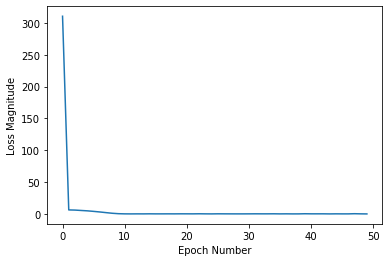

In [23]:
#將Layer放入Model中
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(units=32),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)

    ])
# model = tf.keras.Sequential()  
# # 輸入層
# #model.add(Dense(units=3, input_dim=1, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=10, input_dim=9, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 隱藏層
# #model.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=20, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=30, kernel_initializer='uniform', activation='relu'))
# model.add(tf.keras.layers.Dense(units=40, kernel_initializer='uniform', activation='relu', kernel_regularizer='l2'))
# model.add(tf.keras.layers.Dropout(0.2))

# # 輸出層
# #model.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# model.add(tf.keras.layers.Dense(units=1)) #如果我們再做二元分類，輸出層就要使用sigmoid
#print("\n[Info] Show model summary...")  
model.summary()
print("\n[Info] 訓練中...")  
# 定義 tensorboard callback
tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs')]



#compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'], callbacks=tensorboard_callback) 

 
# train_history = model.fit(x=X_dropped, y=Y_dropped,
#                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
#                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
 
train_history = model.fit(x=X_dropped, y=Y_dropped,
               #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
               validation_split=0.25, epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
# train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2) 
 
# train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
print("Finished training the model")
model.save(save_model)

plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'])
plt.show()


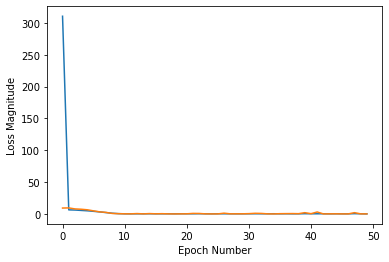

In [24]:
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(train_history.history['loss'], label = 'loss')

#plt.show()
#plt.ylabel("accuracy")
plt.plot(train_history.history['val_loss'], label = 'accuracy')# 準確度

plt.show()

In [25]:
#import matplotlib.pyplot as plt

def acc_draw(hist):
    plt.plot(hist.history['accuracy'], label = 'train')
    plt.plot(hist.history['val_accuracy'], label = 'validation')
    plt.title("train acc vs validation acc")
    plt.xlabel("Epochs")
    plt.ylabel("acc")
    plt.legend()
    plt.show()
def loss_draw(hist):
    plt.style.use('ggplot')
    plt.plot(hist.history['loss'], label = 'train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.title("train loss vs validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
 

In [26]:
#model.predict(X_dropped_test)

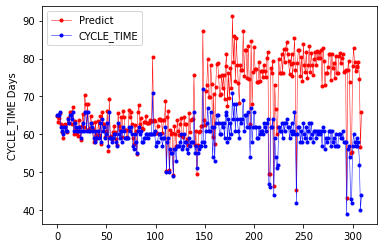

In [41]:
# df_test3.info()
#model = tf.keras.models.load_model(save_model)
# print(model.predict(df_test3))

# plt.xlabel('Seq Number')
plt.ylabel("CYCLE_TIME Days")

plt.plot(model.predict(X_dropped_test), label = "Predict", color='red', marker='.',linewidth = '0.5')
plt.plot(Y_dropped_test, label = "CYCLE_TIME", color='blue', marker='.',linewidth = '0.5')
plt.legend()
plt.show()

In [28]:
y_predict = model.predict(X_dropped_test)

df2_test['predict'] = y_predict
df_test['predict'] = y_predict

In [29]:
df2_test
df_test['predict'] = y_predict
df_test

,DATA_DATE,IDX,LOT_ID,STATUS,CHIPNAME,LAYER,REMAIN_LAYER_SEQ,OP_NO,REMAIN_OP_SEQ,PRIORITY,...,WL,WS,WT,ZL,ACTUAL_WP_OUT,PROCESSED_DAYS,CYCLE_TIME,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict
402,2020-12-20 07:30:00,535158,AWP609000,WAITING,CHIP266,PV,1.0,PV.CQC20,18.0,4,...,NaN,NaN,NaN,NaN,2020-12-21 18:12:00,64,65,1,2.24,64.875122
403,2020-12-20 07:30:00,535159,AWP610000,PROCESSING,CHIP266,PV,1.0,PV.EEA10,8.0,4,...,NaN,NaN,NaN,NaN,2020-12-21 04:22:00,64,65,0,2.24,63.374466
404,2020-12-20 07:30:00,535093,AWP535000,WAITING,CHIP266,PV,1.0,PV.FFL10,2.0,4,...,NaN,NaN,NaN,NaN,2020-12-20 13:52:00,65,65,0,2.24,64.241562
405,2020-12-20 07:30:00,535018,AWP468000,PROCESSING,CHIP266,PV,1.0,PV.FFL10,2.0,4,...,NaN,NaN,NaN,NaN,2020-12-20 09:23:00,66,66,0,2.24,65.497070
406,2020-12-20 07:30:00,535434,AWP864000,PROCESSING,CHIP266,5M,2.0,5M.EEM10,29.0,4,...,NaN,NaN,NaN,NaN,2020-12-22 21:07:00,60,62,2,5.12,62.633167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2020-12-20 07:30:00,538130,AWT311000,PROCESSING,CHIP266,2P,15.0,2P.WWM10,339.0,4,...,NaN,NaN,NaN,NaN,2021-01-22 22:03:00,24,57,33,37.25,77.912956
777,2020-12-20 07:30:00,538131,AWT312000,WAITING,CHIP266,6P,14.0,6P.PQX20,336.0,4,...,NaN,NaN,NaN,NaN,2021-01-24 00:46:00,24,58,34,36.07,79.071609
778,2020-12-20 07:30:00,538740,AWT867000,PROCESSING,CHIP266,1N,20.0,1N.PPK10,410.0,4,...,NaN,NaN,NaN,NaN,2021-01-25 13:05:00,16,52,36,43.76,74.559868
779,2020-12-20 07:30:00,539083,AXA190000,PROCESSING,CHIP266,6N,22.0,6N.IIB10,434.0,1,...,NaN,NaN,NaN,NaN,2021-01-19 00:37:00,11,40,29,47.81,56.646118


In [52]:
#df2_test['diff'] = (df2_test['predict'] - df2_test['REMAIN_DAYS']).abs().astype(int) 
# df2_test['diff'] =abs(df2_test['REMAIN_DAYS'].apply(np.floor)-df2_test['predict'].apply(np.floor))

df2_test['diff'] = (df2_test['predict'] - df2_test['CYCLE_TIME']).abs().astype(int) 
 
#sector = df2_test.groupby("diff")
sector=df2_test.groupby(['diff']).agg(count_col=pd.NamedAgg(column="PRIORITY", aggfunc="count"))

#.cumsum()

percetage = pd.DataFrame({'Percentage': df2_test.groupby(('diff')).size() / len(df2_test)})


In [53]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,CYCLE_TIME,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict,diff
402,WAITING,PV,1.0,18.0,4,25,1,64,65,1,2.24,64.875122,1
403,PROCESSING,PV,1.0,8.0,4,25,1,64,65,0,2.24,63.374466,2
404,WAITING,PV,1.0,2.0,4,25,1,65,65,0,2.24,64.241562,1
405,PROCESSING,PV,1.0,2.0,4,25,1,66,66,0,2.24,65.497070,1
406,PROCESSING,5M,2.0,29.0,4,25,1,60,62,2,5.12,62.633167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,PROCESSING,2P,15.0,339.0,4,25,1,24,57,33,37.25,77.912956,20
777,WAITING,6P,14.0,336.0,4,25,1,24,58,34,36.07,79.071609,21
778,PROCESSING,1N,20.0,410.0,4,25,1,16,52,36,43.76,74.559868,22
779,PROCESSING,6N,22.0,434.0,1,25,1,11,40,29,47.81,56.646118,16


In [54]:
#result = pd.concat([df_test, df2_test], axis=1)

#df2_test['diff','predict']
# df2_test.groupby(["diff"])["CHIPNAME"].count()

# state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
# state = df.groupby(['state']).agg({'sales': 'sum'})
# state_office.div(state, level='state') * 100

In [55]:
df2_test

,STATUS,LAYER,REMAIN_LAYER_SEQ,REMAIN_OP_SEQ,PRIORITY,WIP_QTY,IS_MAIN_ROUTE,PROCESSED_DAYS,CYCLE_TIME,REMAIN_DAYS,LAYER_REMAIN_DAYS,predict,diff
402,WAITING,PV,1.0,18.0,4,25,1,64,65,1,2.24,64.875122,1
403,PROCESSING,PV,1.0,8.0,4,25,1,64,65,0,2.24,63.374466,2
404,WAITING,PV,1.0,2.0,4,25,1,65,65,0,2.24,64.241562,1
405,PROCESSING,PV,1.0,2.0,4,25,1,66,66,0,2.24,65.497070,1
406,PROCESSING,5M,2.0,29.0,4,25,1,60,62,2,5.12,62.633167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,PROCESSING,2P,15.0,339.0,4,25,1,24,57,33,37.25,77.912956,20
777,WAITING,6P,14.0,336.0,4,25,1,24,58,34,36.07,79.071609,21
778,PROCESSING,1N,20.0,410.0,4,25,1,16,52,36,43.76,74.559868,22
779,PROCESSING,6N,22.0,434.0,1,25,1,11,40,29,47.81,56.646118,16


In [56]:
#df2_test.describe


In [57]:
percetage

,Percentage
diff,
0,0.096774
1,0.080645
2,0.106452
3,0.090323
4,0.070968
5,0.032258
6,0.019355
7,0.003226
8,0.012903


In [58]:
percetage['Percentage'].cumsum()

diff
0     0.096774
1     0.177419
2     0.283871
3     0.374194
4     0.445161
5     0.477419
6     0.496774
7     0.500000
8     0.512903
9     0.538710
10    0.561290
11    0.564516
12    0.606452
13    0.632258
14    0.664516
15    0.716129
16    0.732258
17    0.806452
18    0.858065
19    0.903226
20    0.967742
21    0.990323
22    1.000000
Name: Percentage, dtype: float64

In [59]:
df_test[['REMAIN_DAYS','predict']].describe()

,REMAIN_DAYS,predict
count,310.000000,310.000000
mean,16.725806,69.173683
std,11.717231,9.244258
min,0.000000,43.125851
25%,7.000000,61.992695
50%,14.500000,66.551159
75%,28.000000,77.495167
max,36.000000,91.159668


In [60]:
import seaborn as sns

<AxesSubplot:>

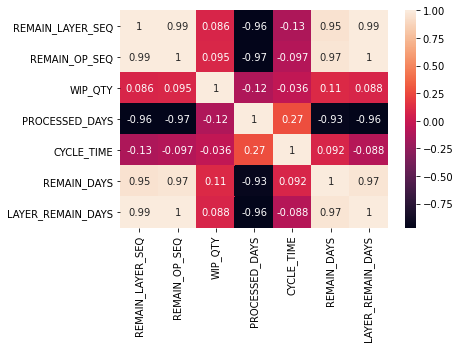

In [61]:
 
Var_Corr = df2_test.drop(columns=['diff','predict']).corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)